# setup

In [2]:
import os, sys, json, random
from collections import Counter
import numpy as np
import torch
from torch.utils.data import Subset


# --- project root & local modules (same pattern as your notebook) ---
PROJ_ROOT = "/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation"
sys.path.append(os.path.join(PROJ_ROOT, "src"))

# Dataset root (same pattern as your notebook)
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = "dataset_full_top999"

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

from otu_taxa.dataloaders_unk_balance_ranks import (
    OTUTaxaDataset,
    MaskingConfig,
    make_collator_balanced_rank,
    build_tax2ancestor_at_ranks,
)



In [3]:
seed = 123

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

TEST_N = min(20_000, N)
VAL_N  = min(20_000, N - TEST_N)

all_idx = list(range(N))
random.shuffle(all_idx)

test_idx  = sorted(all_idx[:TEST_N])
val_idx   = sorted(all_idx[TEST_N:TEST_N + VAL_N])
train_idx = sorted(all_idx[TEST_N + VAL_N:])

print(f"[SPLIT] Train={len(train_idx)}  Val={len(val_idx)}  Test={len(test_idx)}  (Total N={N})")

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)


[INFO] Dataset size: N=1836250
[SPLIT] Train=1796250  Val=20000  Test=20000  (Total N=1836250)


# Collect OTUs per split

In [ ]:
def collect_otus(subset):
    otu_set = set()
    otu_counts = Counter()
    total_positions = 0

    for rec in subset:
        otus = rec["otus"]          
        otu_set.update(otus)
        otu_counts.update(otus)
        total_positions += len(otus)

    return otu_set, otu_counts, total_positions


In [6]:
train_otus, train_counts, train_pos = collect_otus(train_ds)
test_otus,  test_counts,  test_pos  = collect_otus(test_ds)

print("Unique OTUs in train:", len(train_otus))
print("Unique OTUs in test :", len(test_otus))


Unique OTUs in train: 62200
Unique OTUs in test : 59446


# zero shot? searching unique OTUs in TEST that are not in train

In [7]:
unseen_test_otus = test_otus - train_otus

print("Unseen OTUs in test (not in train):", len(unseen_test_otus))
print("Fraction of test OTUs unseen:",
      len(unseen_test_otus) / len(test_otus) if test_otus else 0.0)


Unseen OTUs in test (not in train): 0
Fraction of test OTUs unseen: 0.0


# split groups in Train, support and query

Zero-shot OTU generalization
Question: Can the model infer taxonomy for an OTU it has never seen before? 

* Target OTUs are completely absent during pre training
* OTUs appear only at test time
* Taxonomy is masked at evaluation
* The model must infer taxonomy using:
* co-occurrence context
* taxonomy structure learned from other OTUs


In [35]:
import os, json
from collections import Counter
import pandas as pd

def compute_otu_sample_prevalence_from_jsonl(dataset_dir: str):
    """
    Returns:
      otu_counts: Counter {otu_id: n_samples_where_otu_appears}
      df: pandas DataFrame with columns:
          otu_id, n_samples, prevalence
      N: total number of samples
    """
    jsonl_path = os.path.join(dataset_dir, "samples.jsonl")

    otu_counts = Counter()
    N = 0

    with open(jsonl_path, "r") as f:
        for line in f:
            rec = json.loads(line)
            otus = rec["otus"]

            # Ensure we count each OTU at most once per sample
            # (even if duplicates were present for some reason)
            for o in set(otus):
                otu_counts[o] += 1

            N += 1

    # Build a dataframe (sorted by most prevalent OTUs first)
    df = (
        pd.DataFrame({"otu_id": list(otu_counts.keys()),
                      "n_samples": list(otu_counts.values())})
        .assign(prevalence=lambda x: x["n_samples"] / N)
        .sort_values(["n_samples", "otu_id"], ascending=[False, True])
        .reset_index(drop=True)
    )

    return otu_counts, df, N


# Example usage (your dataset_dir from above)
otu_counts, df_otu_prev, N = compute_otu_sample_prevalence_from_jsonl(dataset_dir)

print("Total samples N =", N)
print("Unique OTUs observed in dataset =", len(otu_counts))
print(df_otu_prev.head(10))


Total samples N = 1836250
Unique OTUs observed in dataset = 62200
   otu_id  n_samples  prevalence
0       3     370928    0.202003
1      25     332011    0.180809
2      24     328143    0.178703
3      33     304062    0.165589
4      16     291865    0.158946
5       5     288444    0.157083
6     223     280088    0.152533
7      22     269393    0.146708
8      56     266771    0.145280
9      21     264155    0.143856


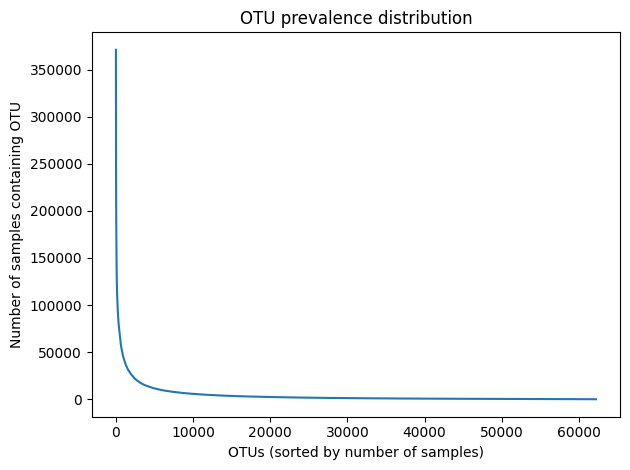

In [46]:
import matplotlib.pyplot as plt
\
# Build OTU-level dataframe (if not already built)
df_otu = (
    pd.DataFrame({
        "otu_id": list(otu_counts.keys()),
        "n_samples": list(otu_counts.values()),
    })
    .sort_values("n_samples", ascending=False)   # rare → common
    .reset_index(drop=True)
)

plt.figure()
plt.plot(df_otu["n_samples"].values)
plt.xlabel("OTUs (sorted by number of samples)")
plt.ylabel("Number of samples containing OTU")
plt.title("OTU prevalence distribution")
plt.tight_layout()
plt.show()


90% OTUs ≤ 9335 samples
95% OTUs ≤ 17739 samples
99% OTUs ≤ 59344 samples


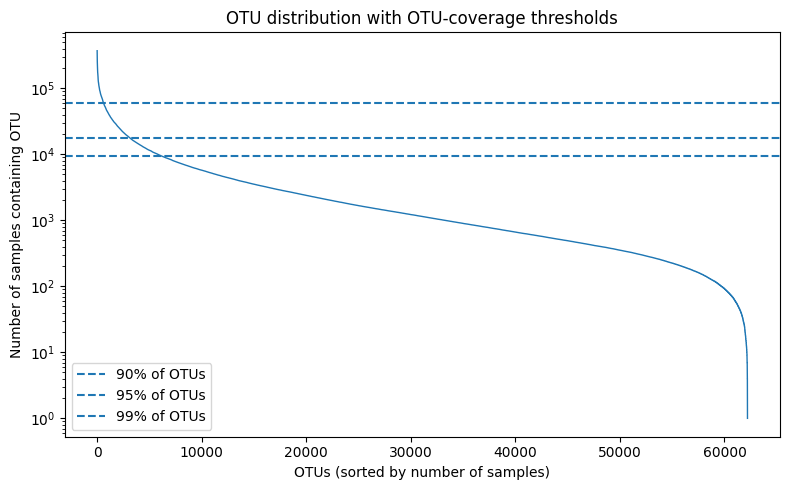

In [48]:

# counts = number of samples per OTU, sorted (already computed)
counts = df_otu["n_samples"].values  # ascending

# OTU-coverage quantiles
q90 = np.quantile(counts, 0.90)
q95 = np.quantile(counts, 0.95)
q99 = np.quantile(counts, 0.99)

print(f"90% OTUs ≤ {q90:.0f} samples")
print(f"95% OTUs ≤ {q95:.0f} samples")
print(f"99% OTUs ≤ {q99:.0f} samples")

plt.figure(figsize=(8, 5))
plt.plot(counts, linewidth=1)

plt.axhline(q90, linestyle="--", linewidth=1.5, label="90% of OTUs")
plt.axhline(q95, linestyle="--", linewidth=1.5, label="95% of OTUs")
plt.axhline(q99, linestyle="--", linewidth=1.5, label="99% of OTUs")

plt.yscale('log')
plt.xlabel("OTUs (sorted by number of samples)")
plt.ylabel("Number of samples containing OTU")
plt.title("OTU distribution with OTU-coverage thresholds")
plt.legend()
plt.tight_layout()
plt.show()


# how much samples i get if i sample N OTUs from tthe tail of the OTus? 

In [55]:

def build_tail_pools_by_quantile(df_otu, quantiles=(0.8, 0.85, 0.90)):
    counts = df_otu["n_samples"].values
    pools = {}

    for q in quantiles:
        threshold = np.quantile(counts, q)
        tail_otus = df_otu.loc[
            df_otu["n_samples"] <= threshold, "otu_id"
        ].values

        pools[int(q * 100)] = {
            "threshold_samples": int(threshold),
            "tail_otu_ids": list(tail_otus),
        }

    return pools


tail_pools = build_tail_pools_by_quantile(df_otu)

for q, info in tail_pools.items():
    print(
        f"{q}% tail: OTUs with ≤ {info['threshold_samples']} samples "
        f"({len(info['tail_otu_ids'])} OTUs)"
    )


def run_tail_holdout_experiment(
    otu_to_samples,
    total_samples,
    tail_pools,
    n_sampled_otus_list=(100, 200, 300),
    n_repeats=5,
    seed=0,
):
    rng = random.Random(seed)
    rows = []

    for q, info in tail_pools.items():
        tail_otus = info["tail_otu_ids"]

        for n_sampled_otus in n_sampled_otus_list:
            assert n_sampled_otus <= len(tail_otus)

            for rep in range(n_repeats):
                sampled_otus = rng.sample(tail_otus, n_sampled_otus)

                heldout_samples = set()
                for otu in sampled_otus:
                    heldout_samples |= otu_to_samples[otu]

                n_heldout = len(heldout_samples)
                n_train = total_samples - n_heldout

                rows.append({
                    "tail_quantile": q,
                    "n_sampled_otus": n_sampled_otus,
                    "repeat": rep,
                    "train_samples": n_train,
                    "heldout_samples": n_heldout,
                    "heldout_fraction": n_heldout / total_samples,
                })

    return pd.DataFrame(rows)


80% tail: OTUs with ≤ 4445 samples (49760 OTUs)
85% tail: OTUs with ≤ 6168 samples (52870 OTUs)
90% tail: OTUs with ≤ 9335 samples (55980 OTUs)


In [59]:
df_exp = run_tail_holdout_experiment(
    otu_to_samples=otu_to_samples,
    total_samples=N,
    tail_pools=tail_pools,
    n_sampled_otus_list=(100, 200, 300),
    n_repeats=5,
)

#print(df_exp)

summary = (
    df_exp
    .groupby(["tail_quantile", "n_sampled_otus"])
    .agg(
        mean_train_samples=("train_samples", "mean"),
        mean_heldout_samples=("heldout_samples", "mean"),
        mean_heldout_fraction=("heldout_fraction", "mean"),
        std_heldout_fraction=("heldout_fraction", "std"),
    )
    .reset_index()
)
def print_summary_table(df):
    print(
        df.to_string(
            index=False,
            formatters={
                "mean_train_samples": "{:,.0f}".format,
                "mean_heldout_samples": "{:,.0f}".format,
                "mean_heldout_fraction": "{:.3f}".format,
                "std_heldout_fraction": "{:.3f}".format,
            },
        )
    )

print_summary_table(summary)

 tail_quantile  n_sampled_otus mean_train_samples mean_heldout_samples mean_heldout_fraction std_heldout_fraction
            80             100          1,731,505              104,745                 0.057                0.005
            80             200          1,651,720              184,530                 0.100                0.004
            80             300          1,585,724              250,526                 0.136                0.004
            85             100          1,720,050              116,200                 0.063                0.009
            85             200          1,628,085              208,165                 0.113                0.007
            85             300          1,553,674              282,576                 0.154                0.006
            90             100          1,690,157              146,093                 0.080                0.006
            90             200          1,573,053              263,197                 0

# chosing a set of OTUs for k-shot learning



        tail_quantile  n_sampled_otus mean_train_samples mean_heldout_samples mean_heldout_fraction std_heldout_fraction

            80             200          1,651,720              184,530                 0.100                0.004


In [60]:
import os, json, random
from collections import Counter
import numpy as np

def build_prevalence_counts(dataset_dir: str):
    """
    Returns:
      otu_counts: Counter {otu_id: n_samples_where_otu_appears}
      N: total number of samples
    """
    otu_counts = Counter()
    N = 0
    jsonl_path = os.path.join(dataset_dir, "samples.jsonl")

    with open(jsonl_path, "r") as f:
        for line in f:
            rec = json.loads(line)
            for o in set(rec["otus"]):
                otu_counts[o] += 1
            N += 1

    return otu_counts, N


def sample_tail_otus(otu_counts: Counter, tail_quantile: float, n_sampled_otus: int, seed: int = 0):
    """
    Tail quantile definition:
      tail_quantile=0.80 means keep OTUs with counts <= q80 (exclude most abundant 20%).
    Returns:
      selected_otus: list[int]
      threshold: int
      tail_pool: list[int]
    """
    rng = random.Random(seed)

    counts = np.array(list(otu_counts.values()), dtype=np.int64)
    threshold = int(np.quantile(counts, tail_quantile))

    tail_pool = [otu for otu, c in otu_counts.items() if c <= threshold]
    if n_sampled_otus > len(tail_pool):
        raise ValueError(f"Requested {n_sampled_otus} OTUs but tail pool has only {len(tail_pool)}.")

    selected_otus = rng.sample(tail_pool, n_sampled_otus)
    return selected_otus, threshold, tail_pool


def split_samples_and_heldout_stats(dataset_dir: str, selected_otus):
    """
    Splits samples:
      heldout_pool: samples containing >=1 selected OTU
      train_pool: samples containing none of selected OTUs

    Also counts, within heldout_pool only, how many heldout samples each selected OTU appears in.
    Returns:
      train_indices, heldout_indices, heldout_otu_counts
    """
    selected_set = set(selected_otus)
    heldout_indices = []
    train_indices = []
    heldout_otu_counts = Counter()  # for selected OTUs, counted over heldout samples

    jsonl_path = os.path.join(dataset_dir, "samples.jsonl")

    with open(jsonl_path, "r") as f:
        for idx, line in enumerate(f):
            rec = json.loads(line)
            otus_in_sample = set(rec["otus"])

            hit = otus_in_sample & selected_set
            if hit:
                heldout_indices.append(idx)
                # count per-OTU presence in heldout samples (binary per sample)
                for o in hit:
                    heldout_otu_counts[o] += 1
            else:
                train_indices.append(idx)

    return train_indices, heldout_indices, heldout_otu_counts


# -------------------------
# RUN 
# -------------------------
tail_q = 0.80
n_sampled_otus = 200
seed = 123

otu_counts, N = build_prevalence_counts(dataset_dir)

selected_otus, threshold, tail_pool = sample_tail_otus(
    otu_counts,
    tail_quantile=tail_q,
    n_sampled_otus=n_sampled_otus,
    seed=seed,
)

train_idx, heldout_idx, heldout_otu_counts = split_samples_and_heldout_stats(
    dataset_dir,
    selected_otus,
)

n_train = len(train_idx)
n_heldout = len(heldout_idx)

print(f"Tail {int(tail_q*100)}% threshold: OTUs with ≤ {threshold} samples")
print(f"Tail pool size: {len(tail_pool):,} OTUs")
print(f"Selected OTUs: {len(selected_otus)}")
print("")
print(f"Total samples:   {N:,}")
print(f"Train samples:   {n_train:,}")
print(f"Heldout samples: {n_heldout:,}  ({n_heldout/N:.3f} fraction)")
print("")

# Heldout stats: "how many OTUs have at least two samples" (in heldout pool)
counts_in_heldout = np.array([heldout_otu_counts.get(o, 0) for o in selected_otus], dtype=np.int64)

n_at_least_2 = int(np.sum(counts_in_heldout >= 2))
n_at_least_5 = int(np.sum(counts_in_heldout >= 5))
n_at_least_10 = int(np.sum(counts_in_heldout >= 10))

print("Heldout OTU stats (among the 200 selected OTUs):")
print(f"  OTUs with >= 2 heldout samples:  {n_at_least_2} / {len(selected_otus)}")
print(f"  OTUs with >= 5 heldout samples:  {n_at_least_5} / {len(selected_otus)}")
print(f"  OTUs with >=10 heldout samples:  {n_at_least_10} / {len(selected_otus)}")
print("")
print("Counts per selected OTU within heldout pool:")
print(f"  min={counts_in_heldout.min()}, median={int(np.median(counts_in_heldout))}, mean={counts_in_heldout.mean():.2f}, max={counts_in_heldout.max()}")


Tail 80% threshold: OTUs with ≤ 4445 samples
Tail pool size: 49,760 OTUs
Selected OTUs: 200

Total samples:   1,836,250
Train samples:   1,651,900
Heldout samples: 184,350  (0.100 fraction)

Heldout OTU stats (among the 200 selected OTUs):
  OTUs with >= 2 heldout samples:  200 / 200
  OTUs with >= 5 heldout samples:  200 / 200
  OTUs with >=10 heldout samples:  200 / 200

Counts per selected OTU within heldout pool:
  min=19, median=843, mean=1207.99, max=4439


In [65]:
# Current notebook directory
out_dir = Path.cwd()

out = {
    "tail_quantile": tail_q,
    "threshold_samples": threshold,
    "n_sampled_otus": n_sampled_otus,
    "seed": seed,
    "selected_otus": selected_otus,
    "n_total_samples": N,
    "n_train_samples": n_train,
    "n_heldout_samples": n_heldout,
    "train_indices": train_idx,
    "heldout_indices": heldout_idx,
}

out_path = out_dir / f"split_tail{int(tail_q*100)}_nOTU{n_sampled_otus}_seed{seed}.json"

with open(out_path, "w") as f:
    json.dump(out, f, indent=2)

print("Split saved to:", out_path)


Split saved to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/notebooks/test_one_shot/split_tail80_nOTU200_seed123.json
